In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Skripsi

/content/drive/MyDrive/Skripsi


In [ ]:
import numpy as np
import pandas as pd
import datetime
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import os
import shutil
import keras_tuner as kt
import utils.time_series_processing as tsp
import utils.visualisation as vs

In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
TICKER = "TLKM"
SEQ_LEN = 60
PRED_HORIZON = 22
VAL_SPLIT = 0.2
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
df = pd.read_csv(
    f"./data/{TICKER}/data_integrasi_{TICKER}.csv",
    index_col=0,
    parse_dates=[0],
    date_format="%Y-%m-%d"
    )
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,3386.848145,3437.147869,3353.314995,3437.147869,42258000,-0.234899
2022-07-12,3361.698242,3403.614679,3361.698242,3403.614679,43399800,-0.116959
2022-07-13,3303.015137,3378.464721,3294.631850,3361.698147,96218200,-0.230263
2022-07-14,3370.081543,3370.081543,3269.482094,3303.015244,68708500,-0.182482
2022-07-15,3479.064209,3529.363932,3361.698187,3386.848049,146093800,-0.158824
...,...,...,...,...,...,...
2025-07-25,2820.000000,2830.000000,2780.000000,2810.000000,41296200,-0.066406
2025-07-28,2860.000000,2870.000000,2830.000000,2870.000000,40193800,-0.036199
2025-07-29,2880.000000,2880.000000,2840.000000,2870.000000,46357400,-0.192308


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2022-07-11 to 2025-07-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           732 non-null    float64
 1   High            732 non-null    float64
 2   Low             732 non-null    float64
 3   Open            732 non-null    float64
 4   Volume          732 non-null    int64  
 5   nilai_sentimen  732 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 40.0 KB


In [ ]:
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,3386.848145,3437.147869,3353.314995,3437.147869,42258000,-0.234899
2022-07-12,3361.698242,3403.614679,3361.698242,3403.614679,43399800,-0.116959
2022-07-13,3303.015137,3378.464721,3294.631850,3361.698147,96218200,-0.230263
2022-07-14,3370.081543,3370.081543,3269.482094,3303.015244,68708500,-0.182482
2022-07-15,3479.064209,3529.363932,3361.698187,3386.848049,146093800,-0.158824
...,...,...,...,...,...,...
2025-07-25,2820.000000,2830.000000,2780.000000,2810.000000,41296200,-0.066406
2025-07-28,2860.000000,2870.000000,2830.000000,2870.000000,40193800,-0.036199
2025-07-29,2880.000000,2880.000000,2840.000000,2870.000000,46357400,-0.192308


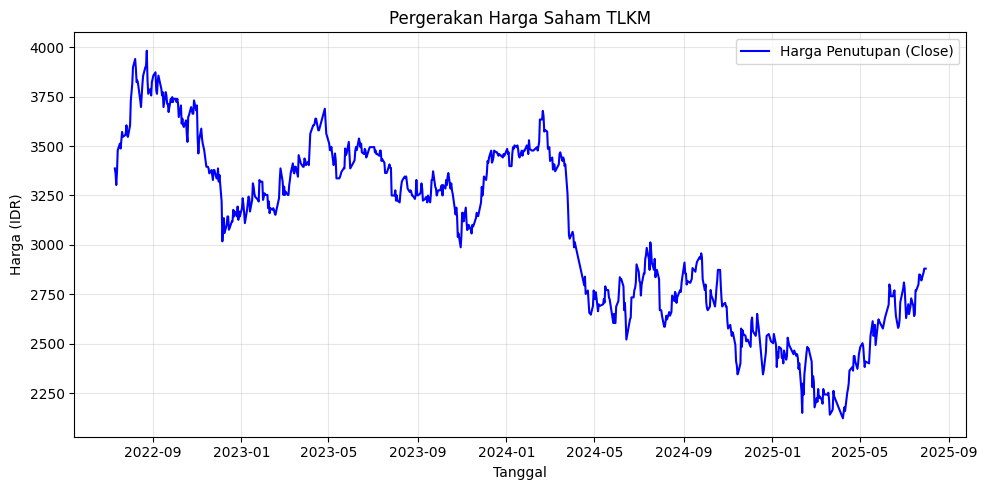

In [ ]:
vs.plot_data(df, TICKER)

In [ ]:
df = df[["Close", "Volume", "nilai_sentimen"]]
df

,Close,Volume,nilai_sentimen
tanggal,,,
2022-07-11,3386.848145,42258000,-0.234899
2022-07-12,3361.698242,43399800,-0.116959
2022-07-13,3303.015137,96218200,-0.230263
2022-07-14,3370.081543,68708500,-0.182482
2022-07-15,3479.064209,146093800,-0.158824
...,...,...,...
2025-07-25,2820.000000,41296200,-0.066406
2025-07-28,2860.000000,40193800,-0.036199
2025-07-29,2880.000000,46357400,-0.192308


In [ ]:
scaler, data_scaled, X_all, y_all, X_train, y_train, X_val, y_val, train_dates, val_dates = tsp.prepare_data_time_series(df)

In [ ]:
print("Train samples:", X_train.shape[0], "val samples:", X_val.shape[0])

Train samples: 520 val samples: 131


In [ ]:
joblib.dump(scaler, f"./data/{TICKER}/scaler_sentimen.pkl")

['./data/TLKM/scaler_sentimen.pkl']

## Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
## Reset/Ulang Tuning

# tuning_dir = f'model/{TICKER}/{TICKER}_lstm_tuning'

# if os.path.exists(tuning_dir):
#     shutil.rmtree(tuning_dir)

### persiapan

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
earlystop = callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

In [ ]:
last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date + datetime.timedelta(days=1), periods=PRED_HORIZON)
#future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=PRED_HORIZON, freq='B')
last_seq = data_scaled[-SEQ_LEN:]

###LSTM

#### Hyper Parameter Tunning

In [ ]:
def build_hypermodel(hp, seq_len, n_features, pred_horizon):
    hp_units1 = hp.Int('lstm_units1', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('lstm_units2', min_value=16, max_value=128, step=16)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)

    model = models.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.LSTM(hp_units1, return_sequences=True),
        layers.LSTM(hp_units2, return_sequences=False),
        layers.Dropout(hp_dropout),
        layers.Dense(hp_dense_units, activation="relu"),
        layers.Dense(pred_horizon, activation="linear")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
tuner = kt.RandomSearch(
    lambda hp: build_hypermodel(hp, SEQ_LEN, X_train.shape[2], PRED_HORIZON),
    objective='val_root_mean_squared_error',
    max_trials=20,
    executions_per_trial=1,
    directory=f'model/{TICKER}',
    project_name=f'{TICKER}_lstm_tuning'
)

Reloading Tuner from model/TLKM/TLKM_lstm_tuning/tuner0.json


In [ ]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=BATCH_SIZE,
             callbacks=[callbacks.EarlyStopping('val_loss', patience=5)])

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Hyperparameter Terbaik: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Hyperparameter Terbaik: {'lstm_units1': 32, 'lstm_units2': 32, 'dropout_rate': 0.4, 'dense_units': 16}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │           374 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,830 (54.02 KB)

 Trainable params: 13,830 (54.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model = build_hypermodel(best_hps, SEQ_LEN, X_train.shape[2], PRED_HORIZON)
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │           374 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,830 (54.02 KB)

 Trainable params: 13,830 (54.02 KB)

 Non-trainable params: 0 (0.00 B)

#### Latih Model Terbaik

In [ ]:
history = lstm_model.fit(
    X_all, y_all,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop],
    verbose=2
)

Epoch 1/100
21/21 - 2s - 96ms/step - loss: 0.2079 - root_mean_squared_error: 0.4560
Epoch 2/100
21/21 - 0s - 10ms/step - loss: 0.1035 - root_mean_squared_error: 0.3217
Epoch 3/100
21/21 - 0s - 15ms/step - loss: 0.0523 - root_mean_squared_error: 0.2287
Epoch 4/100
21/21 - 0s - 14ms/step - loss: 0.0335 - root_mean_squared_error: 0.1830
Epoch 5/100
21/21 - 0s - 15ms/step - loss: 0.0232 - root_mean_squared_error: 0.1523
Epoch 6/100
21/21 - 0s - 14ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483
Epoch 7/100
21/21 - 0s - 14ms/step - loss: 0.0187 - root_mean_squared_error: 0.1368
Epoch 8/100
21/21 - 0s - 14ms/step - loss: 0.0172 - root_mean_squared_error: 0.1311
Epoch 9/100
21/21 - 0s - 14ms/step - loss: 0.0176 - root_mean_squared_error: 0.1328
Epoch 10/100
21/21 - 0s - 15ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274
Epoch 11/100
21/21 - 0s - 15ms/step - loss: 0.0141 - root_mean_squared_error: 0.1185
Epoch 12/100
21/21 - 1s - 25ms/step - loss: 0.0141 - root_mean_squared_err

In [ ]:
eval_results = lstm_model.evaluate(X_val, y_val, verbose=0)
print("Hasil evaluasi pada test set (loss, rmse):", eval_results)

Hasil evaluasi pada test set (loss, rmse): [0.004114113282412291, 0.06414135545492172]


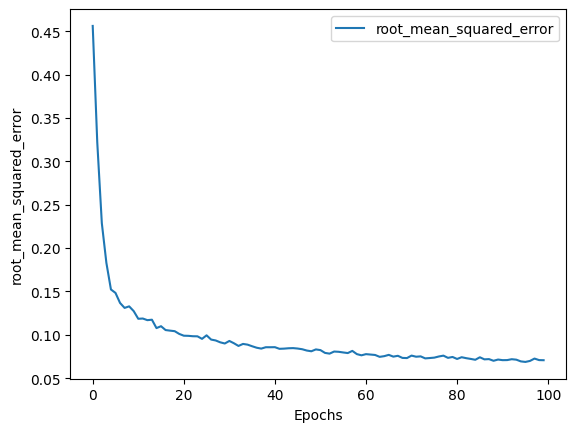

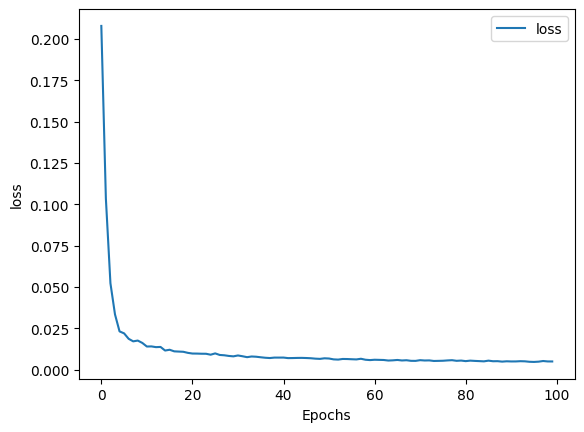

In [ ]:
vs.plotGraphs(history, "root_mean_squared_error")
vs.plotGraphs(history, "loss")

In [ ]:
train_pred = lstm_model.predict(X_train)
val_pred = lstm_model.predict(X_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
pred_22 = tsp.predict_next_days(lstm_model, last_seq, scaler)
print("Prediksi 22 hari ke depan (close):")
print(pred_22)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediksi 22 hari ke depan (close):
[2963.39345961 2959.30351704 2969.62899851 2969.56605245 2957.22341565
 2959.83528937 2958.22002469 2973.5496073  2950.33663989 2955.66899145
 2942.92041904 2940.87843991 2950.47771443 2937.49597562 2940.72805645
 2929.85767042 2955.59163872 2940.35730635 2949.56205978 2935.87134661
 2944.01759772 2950.08197431]


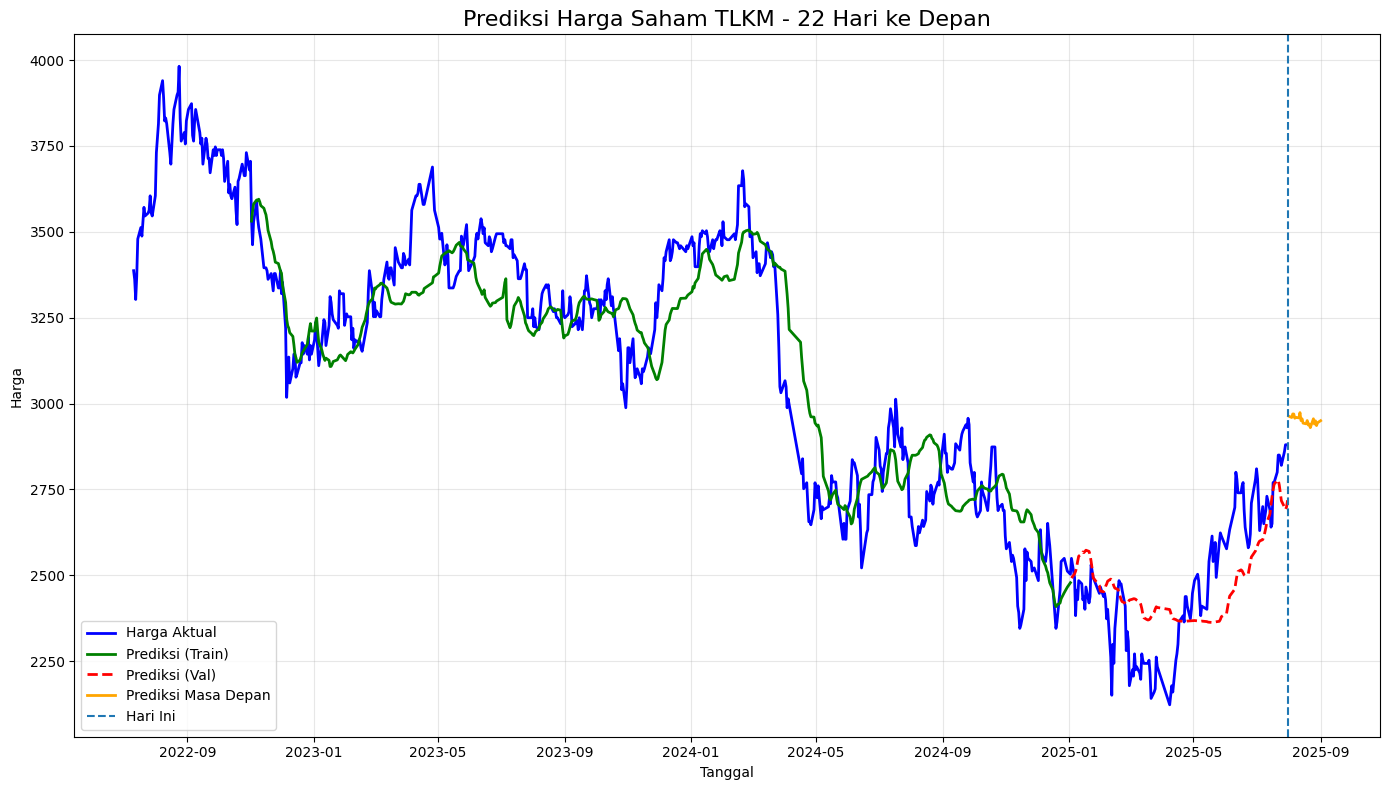

In [ ]:
vs.plot_predictions(
    df, scaler, train_dates, val_dates, train_pred, val_pred,
    future_dates, pred_22, TICKER
)

In [ ]:
lstm_model.save(f"./model/{TICKER}/sentimen_lstm_model.keras")
lstm_model.save(f"./model/{TICKER}/sentimen_lstm_model.h5")

### BiLSTM

#### Hyper Parameter Tunning

In [ ]:
def build_hypermodel(hp, seq_len, n_features, pred_horizon):
    hp_units1 = hp.Int('bilstm_units', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('lstm_units', min_value=16, max_value=128, step=16)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)

    model = models.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.Bidirectional(layers.LSTM(hp_units1, return_sequences=True)),
        layers.LSTM(hp_units2, return_sequences=False),
        layers.Dropout(hp_dropout),
        layers.Dense(hp_dense_units, activation="relu"),
        layers.Dense(pred_horizon, activation="linear")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
tuner = kt.RandomSearch(
    lambda hp: build_hypermodel(hp, SEQ_LEN, X_train.shape[2], PRED_HORIZON),
    objective='val_root_mean_squared_error',
    max_trials=50,
    executions_per_trial=1,
    directory=f'model/{TICKER}',
    project_name=f'{TICKER}_bilstm_tuning'
)

Reloading Tuner from model/TLKM/TLKM_bilstm_tuning/tuner0.json


In [ ]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=BATCH_SIZE,
             callbacks=[callbacks.EarlyStopping('val_loss', patience=5)])

Trial 50 Complete [00h 00m 10s]
val_root_mean_squared_error: 0.08181076496839523

Best val_root_mean_squared_error So Far: 0.07735804468393326
Total elapsed time: 00h 23m 49s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Hyperparameter Terbaik: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Hyperparameter Terbaik: {'bilstm_units': 64, 'lstm_units': 64, 'dropout_rate': 0.5, 'dense_units': 64}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 128)        │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,814 (350.84 KB)

 Trainable params: 89,814 (350.84 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
bilstm_model = build_hypermodel(best_hps, SEQ_LEN, X_train.shape[2], PRED_HORIZON)
bilstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 128)        │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,814 (350.84 KB)

 Trainable params: 89,814 (350.84 KB)

 Non-trainable params: 0 (0.00 B)

#### Latih Model Terbaik

In [ ]:
history = bilstm_model.fit(
    X_all, y_all,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop],
    verbose=2
)

Epoch 1/100
21/21 - 4s - 182ms/step - loss: 0.1598 - root_mean_squared_error: 0.3997
Epoch 2/100
21/21 - 1s - 25ms/step - loss: 0.0274 - root_mean_squared_error: 0.1657
Epoch 3/100
21/21 - 0s - 12ms/step - loss: 0.0129 - root_mean_squared_error: 0.1138
Epoch 4/100
21/21 - 0s - 14ms/step - loss: 0.0104 - root_mean_squared_error: 0.1022
Epoch 5/100
21/21 - 0s - 12ms/step - loss: 0.0100 - root_mean_squared_error: 0.0999
Epoch 6/100
21/21 - 0s - 13ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993
Epoch 7/100
21/21 - 0s - 12ms/step - loss: 0.0092 - root_mean_squared_error: 0.0961
Epoch 8/100
21/21 - 0s - 12ms/step - loss: 0.0087 - root_mean_squared_error: 0.0931
Epoch 9/100
21/21 - 0s - 13ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948
Epoch 10/100
21/21 - 0s - 13ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928
Epoch 11/100
21/21 - 0s - 12ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928
Epoch 12/100
21/21 - 0s - 12ms/step - loss: 0.0081 - root_mean_squared_er

In [ ]:
eval_results = bilstm_model.evaluate(X_val, y_val, verbose=0)
print("Hasil evaluasi pada test set (loss, rmse):", eval_results)

Hasil evaluasi pada test set (loss, rmse): [0.005149707198143005, 0.07176145911216736]


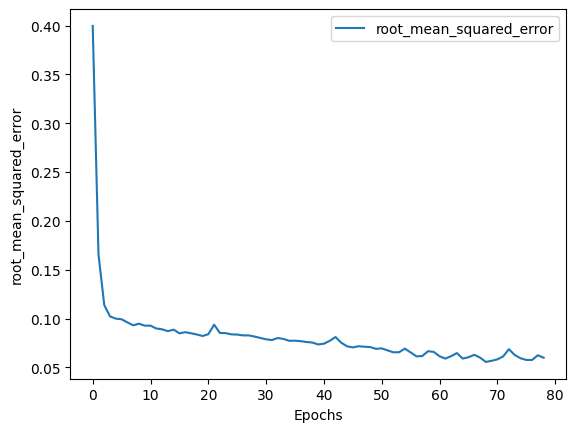

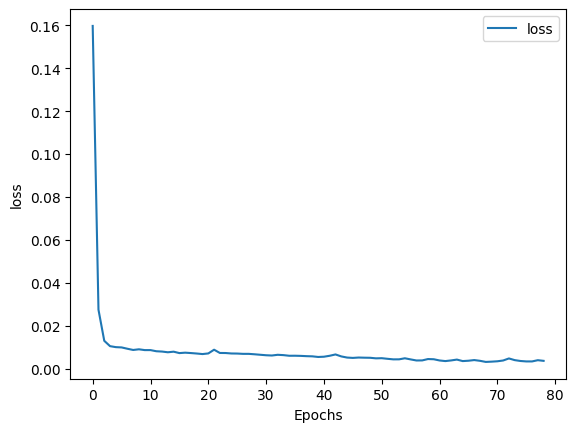

In [ ]:
vs.plotGraphs(history, "root_mean_squared_error")
vs.plotGraphs(history, "loss")

In [ ]:
train_pred = bilstm_model.predict(X_train)
val_pred = bilstm_model.predict(X_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [ ]:
pred_22 = tsp.predict_next_days(bilstm_model, last_seq, scaler)
print("Prediksi 22 hari ke depan (close):")
print(pred_22)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Prediksi 22 hari ke depan (close):
[2833.11162266 2825.50484591 2828.82735629 2832.84886718 2837.52388675
 2847.27105127 2836.06016916 2844.03935831 2846.98341658 2854.48818303
 2838.51595216 2843.80153745 2858.37382795 2857.2411867  2844.87771564
 2857.93597603 2862.7848176  2863.53684574 2851.27804467 2865.48412872
 2866.49292803 2865.76611157]


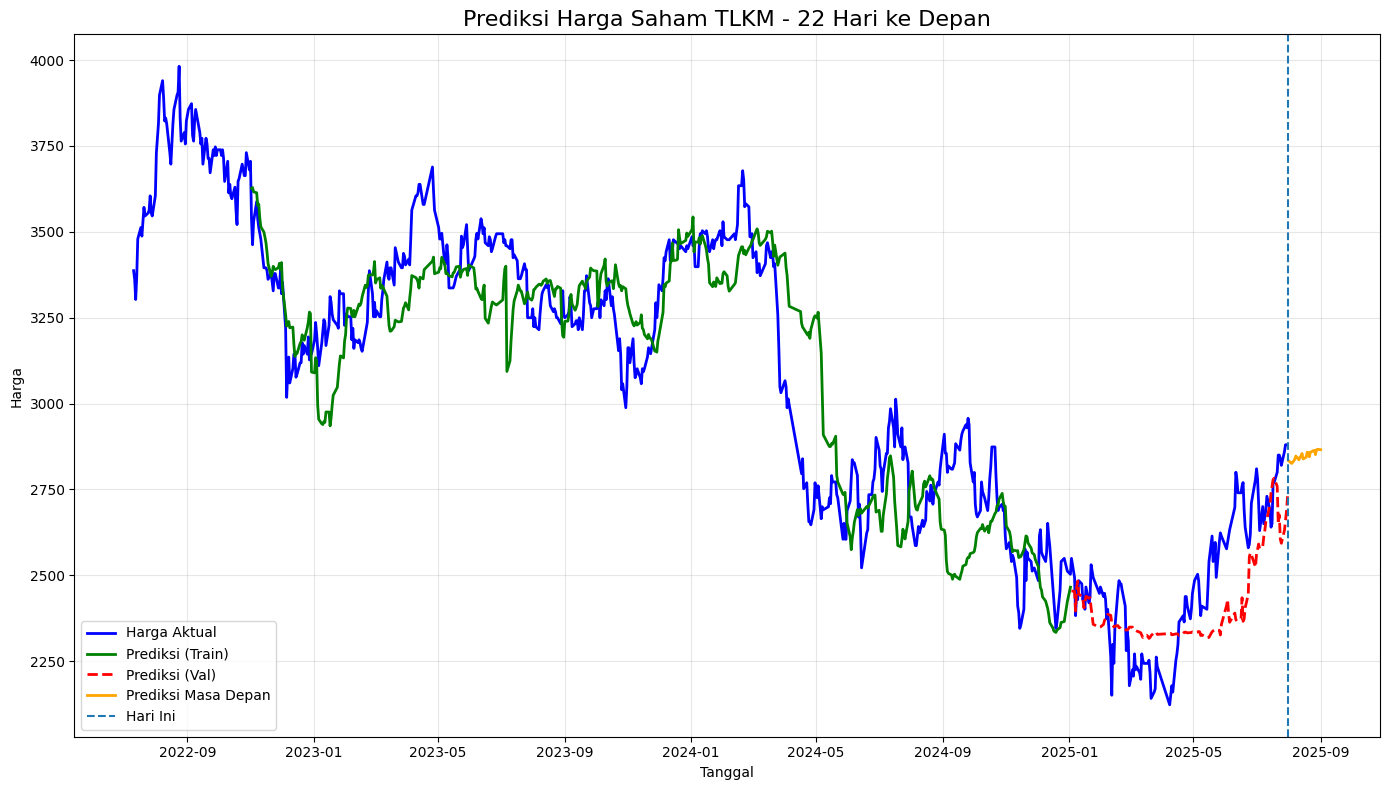

In [ ]:
vs.plot_predictions(
    df, scaler, train_dates, val_dates, train_pred, val_pred,
    future_dates, pred_22, TICKER
)

In [ ]:
bilstm_model.save(f"./model/{TICKER}/sentimen_bilstm_model.keras")
bilstm_model.save(f"./model/{TICKER}/sentimen_bilstm_model.h5")

### GRU

#### Hyper Parameter Tunning

In [ ]:
def build_hypermodel(hp, seq_len, n_features, pred_horizon):
    hp_units1 = hp.Int('gru_units1', min_value=32, max_value=128, step=32)
    hp_units2 = hp.Int('gru_units2', min_value=16, max_value=128, step=16)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)

    model = models.Sequential([
        layers.Input(shape=(seq_len, n_features)),
        layers.GRU(hp_units1, return_sequences=True),
        layers.GRU(hp_units2, return_sequences=False),
        layers.Dropout(hp_dropout),
        layers.Dense(hp_dense_units, activation="relu"),
        layers.Dense(pred_horizon, activation="linear")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
tuner = kt.RandomSearch(
    lambda hp: build_hypermodel(hp, SEQ_LEN, X_train.shape[2], PRED_HORIZON),
    objective='val_root_mean_squared_error',
    max_trials=20,
    executions_per_trial=1,
    directory=f'model/{TICKER}',
    project_name=f'{TICKER}_gru_tuning'
)

In [ ]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=BATCH_SIZE,
             callbacks=[callbacks.EarlyStopping('val_loss', patience=5)])

Trial 20 Complete [00h 00m 10s]
val_root_mean_squared_error: 0.07958521693944931

Best val_root_mean_squared_error So Far: 0.07479894161224365
Total elapsed time: 00h 02m 39s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Hyperparameter Terbaik: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Hyperparameter Terbaik: {'gru_units1': 32, 'gru_units2': 32, 'dropout_rate': 0.2, 'dense_units': 64}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 32)         │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,430 (52.46 KB)

 Trainable params: 13,430 (52.46 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_model = build_hypermodel(best_hps, SEQ_LEN, X_train.shape[2], PRED_HORIZON)
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 60, 32)         │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,430 (52.46 KB)

 Trainable params: 13,430 (52.46 KB)

 Non-trainable params: 0 (0.00 B)

#### Latih Model Terbaik

In [ ]:
history = gru_model.fit(
    X_all, y_all,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop],
    verbose=2
)

Epoch 1/100
21/21 - 2s - 89ms/step - loss: 0.1796 - root_mean_squared_error: 0.4237
Epoch 2/100
21/21 - 0s - 12ms/step - loss: 0.0472 - root_mean_squared_error: 0.2173
Epoch 3/100
21/21 - 0s - 9ms/step - loss: 0.0201 - root_mean_squared_error: 0.1419
Epoch 4/100
21/21 - 0s - 9ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163
Epoch 5/100
21/21 - 0s - 14ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090
Epoch 6/100
21/21 - 0s - 10ms/step - loss: 0.0109 - root_mean_squared_error: 0.1044
Epoch 7/100
21/21 - 0s - 9ms/step - loss: 0.0106 - root_mean_squared_error: 0.1029
Epoch 8/100
21/21 - 0s - 9ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018
Epoch 9/100
21/21 - 0s - 9ms/step - loss: 0.0103 - root_mean_squared_error: 0.1014
Epoch 10/100
21/21 - 0s - 9ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988
Epoch 11/100
21/21 - 0s - 9ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964
Epoch 12/100
21/21 - 0s - 10ms/step - loss: 0.0094 - root_mean_squared_error: 0.0

In [ ]:
eval_results = gru_model.evaluate(X_val, y_val, verbose=0)
print("Hasil evaluasi pada test set (loss, rmse):", eval_results)

Hasil evaluasi pada test set (loss, rmse): [0.003589147701859474, 0.05990949645638466]


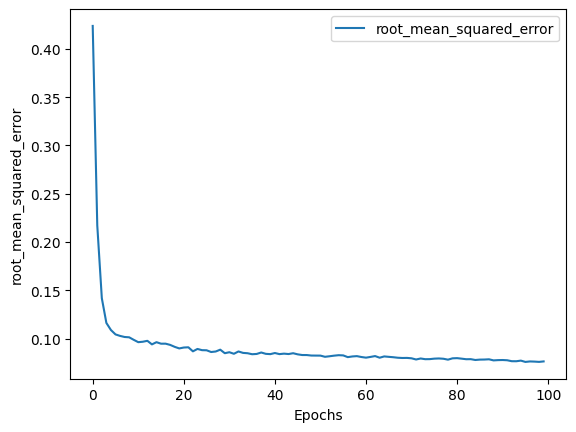

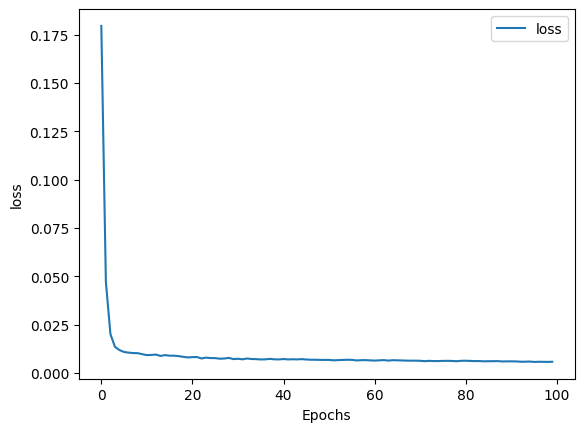

In [ ]:
vs.plotGraphs(history, "root_mean_squared_error")
vs.plotGraphs(history, "loss")

In [ ]:
train_pred = gru_model.predict(X_train)
val_pred = gru_model.predict(X_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
pred_22 = tsp.predict_next_days(gru_model, last_seq, scaler)
print("Prediksi 22 hari ke depan (close):")
print(pred_22)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediksi 22 hari ke depan (close):
[2840.45054619 2840.53665375 2836.74060723 2856.36913993 2849.54204103
 2851.7736895  2849.03841712 2838.64494726 2847.46592918 2854.96936579
 2852.57176357 2847.99382278 2837.68402242 2856.93293939 2845.91521747
 2846.92750762 2852.42392898 2845.46772416 2860.27639485 2851.079011
 2855.30099623 2853.70335202]


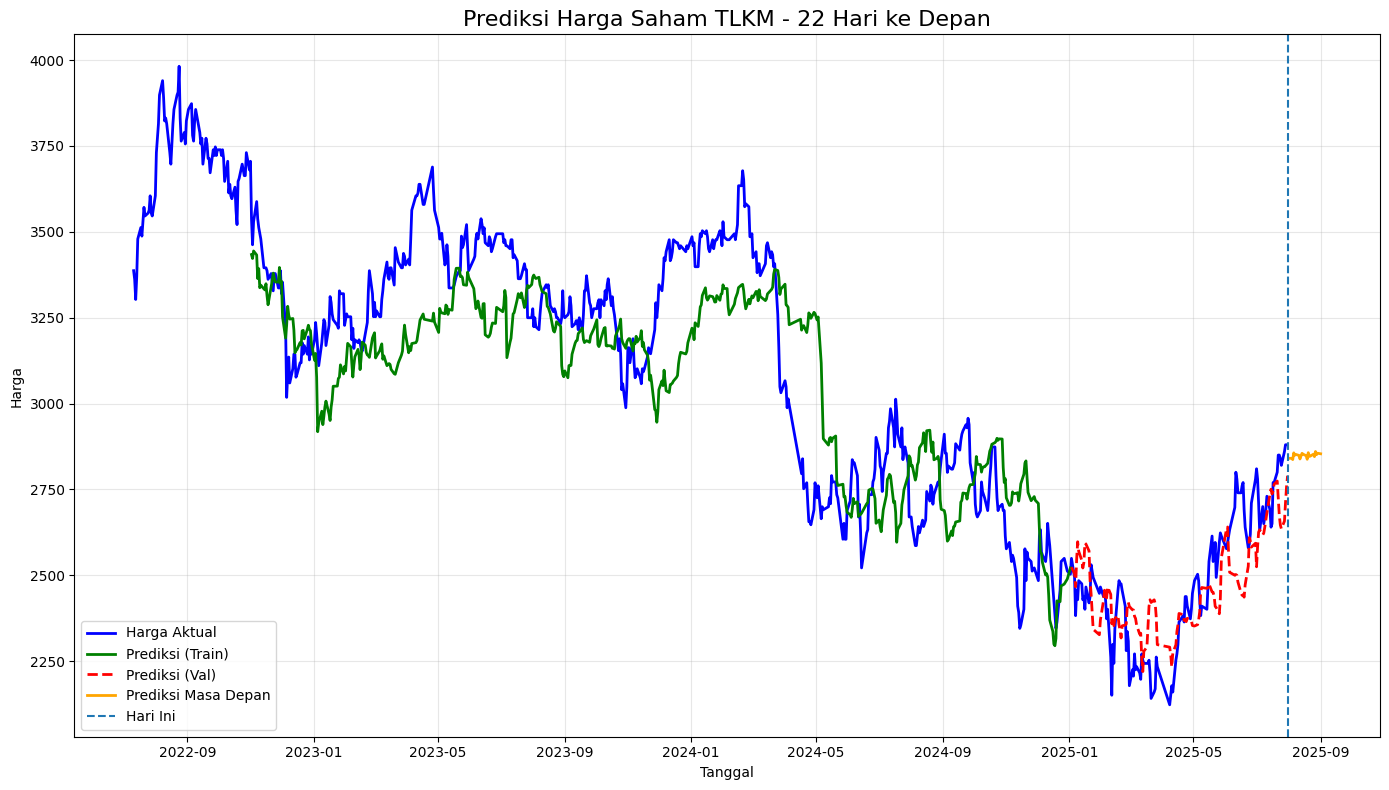

In [ ]:
vs.plot_predictions(
    df, scaler, train_dates, val_dates, train_pred, val_pred,
    future_dates, pred_22, TICKER
)

In [ ]:
gru_model.save(f"./model/{TICKER}/sentimen_gru_model.keras")
gru_model.save(f"./model/{TICKER}/sentimen_gru_model.h5")